In [92]:
from scipy.stats import ttest_ind
import helper 
import xarray as xr 
import numpy as np 
import cmaps as cmap 
import matplotlib.pyplot as plt
import scipy 
import warnings
import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import matplotlib.patheffects as pe
warnings.filterwarnings("ignore")

def rePoPolar(dataset, name):
    print(dataset.values.shape)
    x = dataset.x.values
    y = dataset.y.values
    x, y = np.meshgrid(x, y)

    r = np.sqrt(x**2 + y**2)
    t = np.arctan2(y, x)

    rBins = np.linspace(np.nanmin(r), np.nanmax(r), 120)
    tBins = np.linspace(np.nanmin(t), np.nanmax(t), 360)

    R, T = np.meshgrid(rBins, tBins)
    newX, newY = R * np.cos(T), R * np.sin(T)
    gridded_data = scipy.interpolate.griddata((x.flatten(), y.flatten()), dataset.values.flatten(), (newX.flatten(), newY.flatten()), method='nearest')

    polar = xr.Dataset(
        {
            name: (('r', 'theta'), gridded_data.reshape(R.shape).transpose())
        },
        coords={
            'r': rBins,
            'theta': tBins
        }
    )

    return polar


In [113]:
from file import getGZ 
import urllib.request

def process(mission, times, var, level):
    datasets = []
    for time in times:
        link = f'https://seb.omao.noaa.gov/pub/flight/radar/{mission}/{mission[2:]}_{time}_xy.nc.gz'
        urllib.request.urlretrieve(link, r"C:\Users\deela\Downloads\RTTDR.nc.gz")
        getGZ(r"C:\Users\deela\Downloads\RTTDR.nc.gz")
        dataset = xr.open_dataset(r"C:\Users\deela\Downloads\RTTDR.nc")

        data = dataset[var].sel(level = level)

        temp = rePoPolar(data.squeeze(), 'data')
        newTheta = np.linspace(-np.pi, np.pi, 360, endpoint=False)
        temp = temp.interp(theta = newTheta)    
        temp = temp.sel(r = slice(0, 80))
        temp = temp.interp(r = np.linspace(0, 80, 160, endpoint = False))

        datasets.append(temp)

    datasets = xr.concat(datasets, dim = xr.Variable("time", times))
    print(datasets)

    return datasets['data']

In [218]:
mission = '20251027H2'
time1 = '2230'
time2 = '2509'
var = 'VORT'
height = 3
data = process(mission, [time1, time2], var, height)

if var == 'VORT':
    data = data / 1000

(250, 250)
(250, 250)
<xarray.Dataset> Size: 926kB
Dimensions:  (time: 2, r: 160, theta: 360)
Coordinates:
  * theta    (theta) float64 3kB -3.142 -3.124 -3.107 ... 3.089 3.107 3.124
  * r        (r) float64 1kB 0.0 0.5 1.0 1.5 2.0 ... 77.5 78.0 78.5 79.0 79.5
  * time     (time) <U4 32B '2230' '2509'
Data variables:
    data     (time, r, theta) float64 922kB nan nan nan nan ... nan nan nan nan


In [219]:
from scipy.ndimage import gaussian_filter1d

def getOuterMax(data):
    radial = data.mean('theta')
    diff = (np.diff(radial.values) / np.diff(radial.r))
    diff = gaussian_filter1d(diff, sigma = 1)

    loc = 1 + np.nanargmax(diff) + np.nanargmax(diff[np.nanargmax(diff):])
    print(radial.r.values[np.nanargmax(diff)], radial.r.values[loc])
    # plt.plot(radial.r[1:], diff)
    plt.plot(radial.r, radial)
    plt.axvline(radial.r.values[loc], color = 'black')

    return loc

45.0 45.5
51.5 52.0


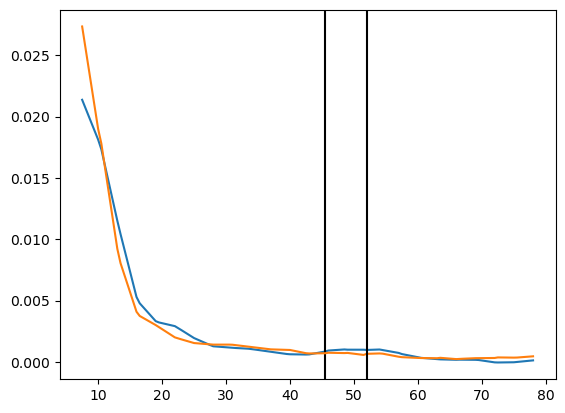

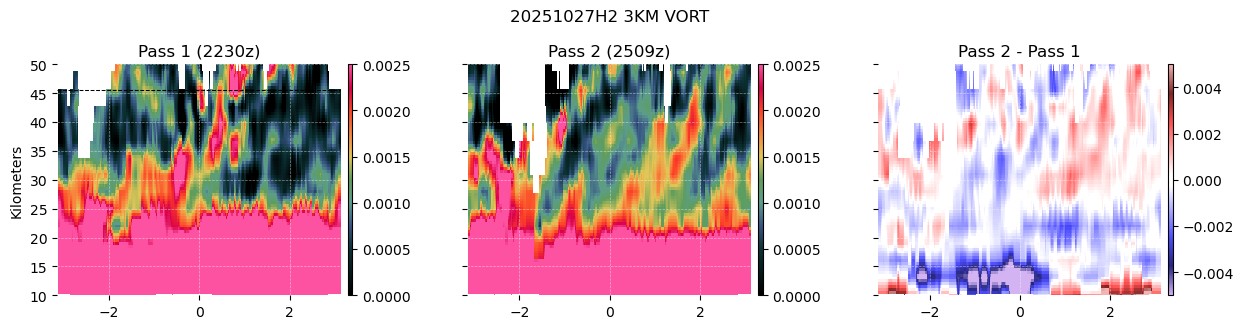

In [220]:
data1 = data.isel(time = 0)
rmax1 = getOuterMax(data1)
data2 = data.isel(time = 1)
rmax2 = getOuterMax(data2)

test = data2 - data1
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for x in range(len(axes)):
    axes[x].set_frame_on(False)
    axes[x].grid(linestyle = '--', alpha = 0.5, color = 'white', linewidth = 0.5, zorder = 9)
    axes[x].set_ylim(10, 50)
    if x in [1, 2]:
        axes[x].set_yticklabels([])

c = axes[0].pcolormesh(test.theta, test.r, data1, cmap = cmap.probs4(), vmin = 0, vmax = 0.0025)
plt.colorbar(c, ax = axes[0], orientation = 'vertical', aspect = 50, pad = .02)
axes[0].axhline(data1.r.values[rmax1], ls = '--', color = 'black', linewidth = 0.75, zorder = 9)

c = axes[1].pcolormesh(test.theta, test.r, data2, cmap = cmap.probs4(), vmin = 0, vmax =  0.0025)
plt.colorbar(c, ax = axes[1], orientation = 'vertical', aspect = 50, pad = .02)
axes[1].axhline(data2.r.values[rmax2], ls = '--', color = 'black', linewidth = 0.75, zorder = 9)

c = axes[2].pcolormesh(test.theta, test.r, test, cmap = cmap.tempAnoms3(), vmin = -0.005, vmax = 0.005)
plt.colorbar(c, ax = axes[2], orientation = 'vertical', aspect = 50, pad = .02)

axes[0].set_ylabel('Kilometers')

axes[0].set_title(f'Pass 1 ({time1}z)')
axes[1].set_title(f'{mission} {height}KM {var}\n\nPass 2 ({time2}z)')
axes[2].set_title('Pass 2 - Pass 1')
# plt.savefig(r"C:\Users\deela\Downloads\diffTDRRadial3.png", dpi = 400, bbox_inches = 'tight')
plt.show()